# Keypoint Heatmap Encoder

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
voc_root = os.path.join(project_root, "data", "VOC2012")

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from data.voc_dataset import VOCDataset
from centernet.encoder import KeypointHeatmapEncoder

In [3]:
dataset = VOCDataset('trainval', root=voc_root)
encoder = KeypointHeatmapEncoder(heatmap_shape=(37,37), std=0.1)

## Encoding

gt_boxes has shape torch.Size([4, 4])
gt_labels has shape torch.Size([4])
Heatmap min/max 0.0/1.0029207468032837


Text(0.5, 1.0, 'Encoded Keypoint Heatmap')

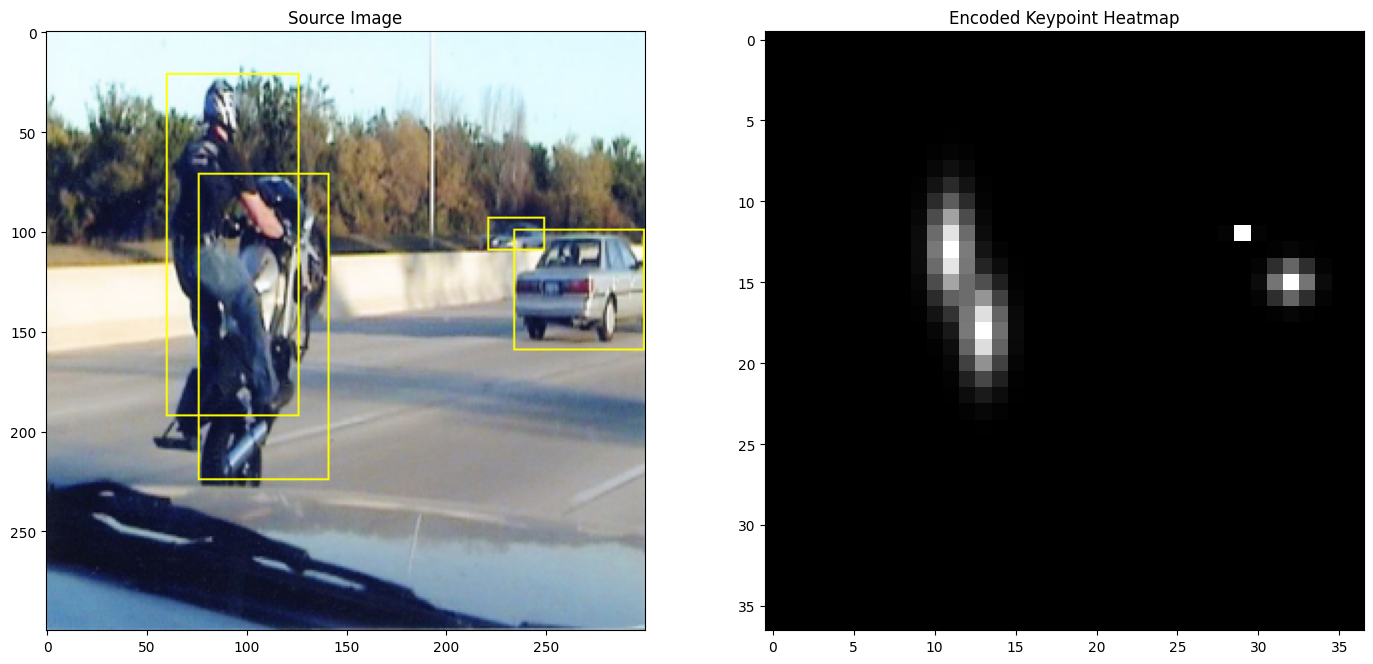

In [4]:
img_tensor, bboxes = dataset[70]
img_tensor = img_tensor.permute(1, 2, 0).contiguous()

img = img_tensor.numpy() * 255
img = img.astype(np.uint8)
height, width, _ = img.shape

gt_boxes = bboxes[:, :4]
gt_labels = bboxes[:, 4]
print("gt_boxes has shape", gt_boxes.shape)
print("gt_labels has shape", gt_labels.shape)

for i, box in enumerate(gt_boxes):
    xmin, ymin, xmax, ymax = box
    umin, vmin = int(xmin * width), int(ymin * height)
    umax, vmax = int(xmax * width), int(ymax * height)
    cv2.rectangle(img, (umin, vmin), (umax, vmax), color=(255, 255, 0), thickness=1)
    
    
center_mask, center_cls_heatmap, center_reg_heatmap = encoder.encode(gt_boxes, gt_labels.int())

heatmap = center_cls_heatmap.sum(dim=0).numpy()
print(f"Heatmap min/max {heatmap.min()}/{heatmap.max()}")

fig, axs = plt.subplots(1, 2, figsize=(17, 8))
axs[0].imshow(img)
axs[0].set_title("Source Image")
axs[1].imshow(heatmap, cmap='gray')
axs[1].set_title("Encoded Keypoint Heatmap")

In [5]:
print("du", center_reg_heatmap[0, center_mask.int() > 0])
print("dv", center_reg_heatmap[1, center_mask.int() > 0])
print("width", center_reg_heatmap[2, center_mask.int() > 0])
print("height", center_reg_heatmap[3, center_mask.int() > 0])

du tensor([0.0450, 0.5440, 0.9300, 0.4310])
dv tensor([0.5377, 0.2063, 0.9367, 0.2214])
width tensor([0.0940, 0.2200, 0.2160, 0.2140])
height tensor([0.0512, 0.5693, 0.1988, 0.5090])


## Decoding

In [6]:
import torch.nn.functional as F

I need to experiment with different kernel size for max pooling to deduce the best approach for detecting peaks. In a way, the kernel size acts as a form of spatial regularization. A larger kernel promotes more global consistency (i.e., fewer, more distinct peaks), while a smaller kernel allows for more local variation (i.e., more, potentially less distinct peaks).

maxpool_1: torch.Size([21, 37, 37]), min/max 0.0/1.0
maxpool_2: torch.Size([21, 37, 37]), min/max 0.0/1.0
maxpool_3: torch.Size([21, 37, 37]), min/max 0.5/0.7310585975646973


Text(0.5, 1.0, 'Sigmoid Kernel Size 5')

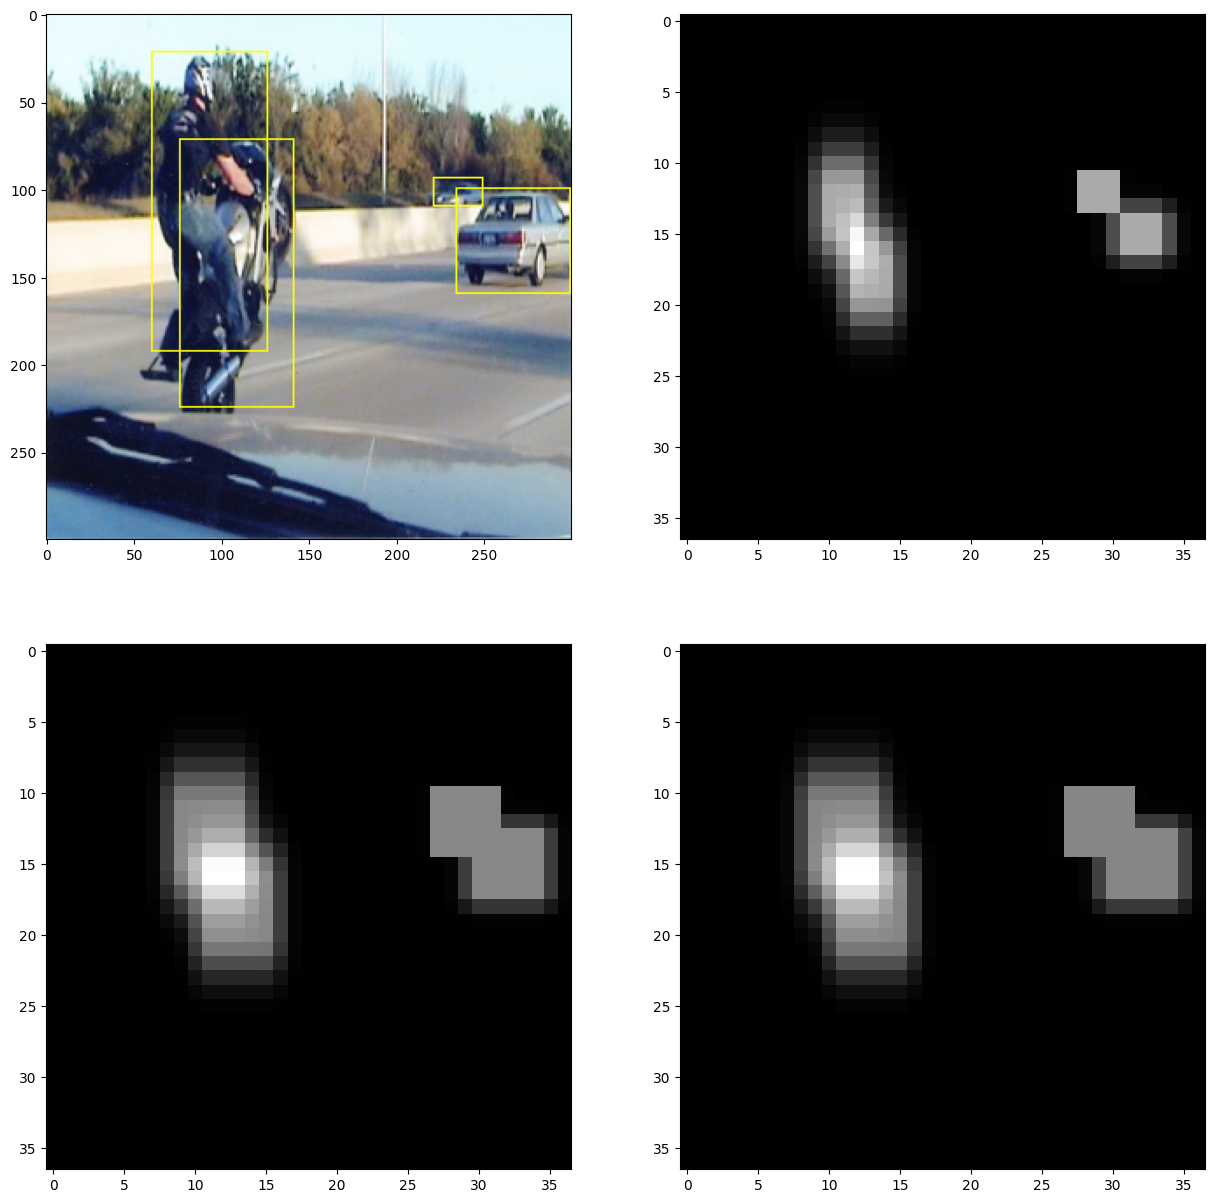

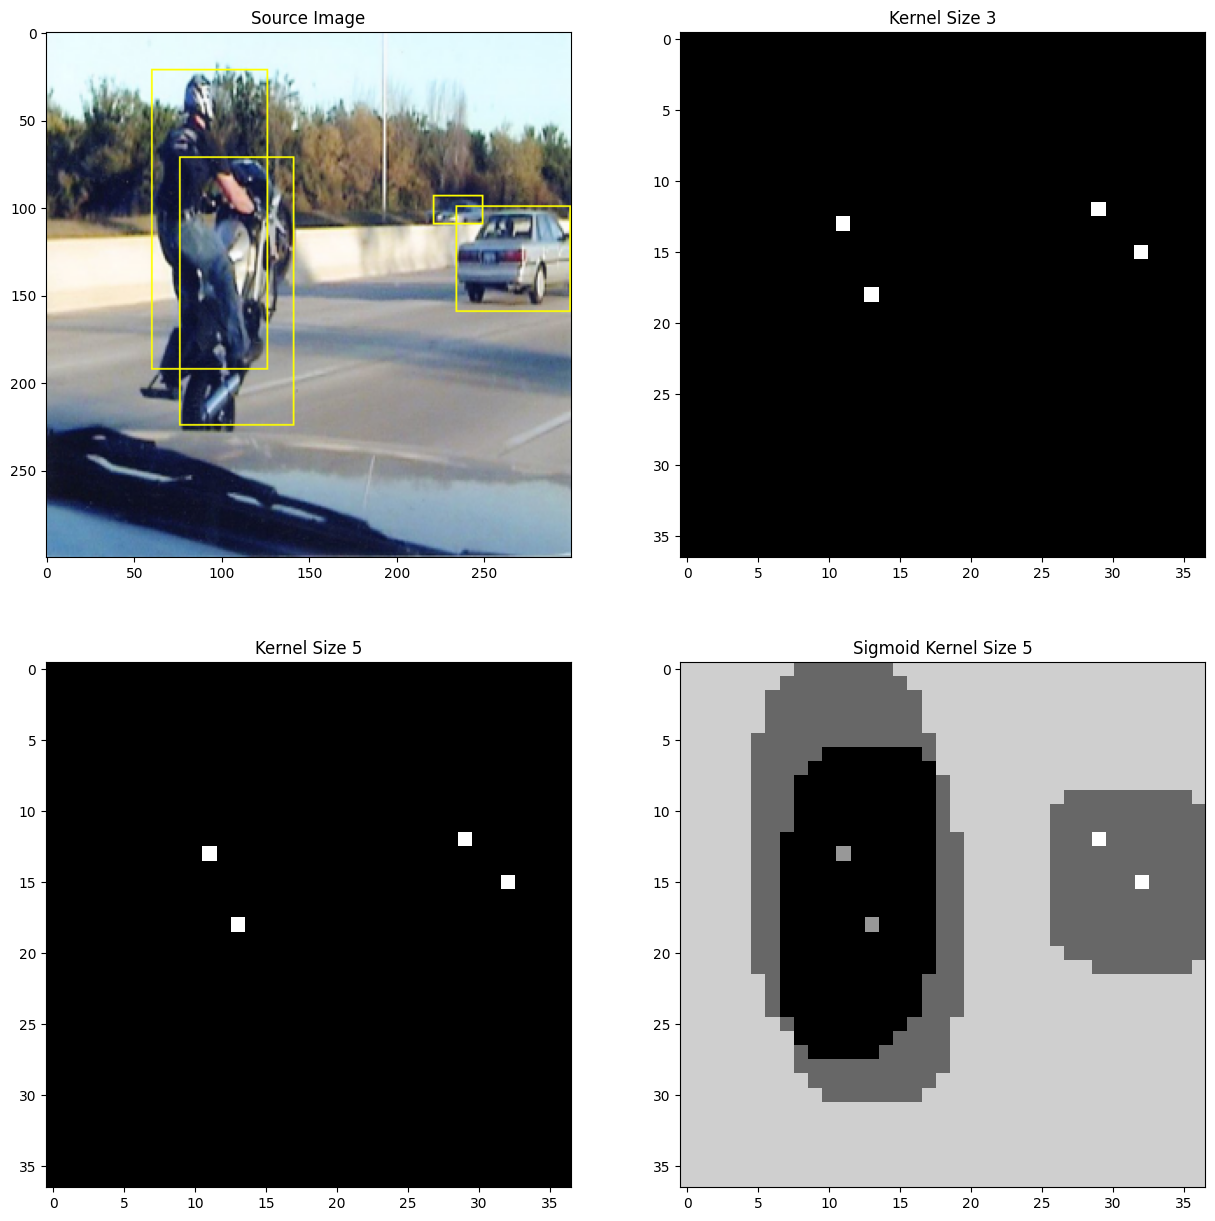

In [7]:
sig_heatmap = F.sigmoid(center_cls_heatmap)

maxpool_1 = F.max_pool2d(center_cls_heatmap, kernel_size=3, padding=1, stride=1)
maxpool_2 = F.max_pool2d(center_cls_heatmap, kernel_size=5, padding=2, stride=1)
maxpool_3 = F.max_pool2d(sig_heatmap, kernel_size=5, padding=2, stride=1)
print(f"maxpool_1: {maxpool_1.shape}, min/max {maxpool_1.min()}/{maxpool_1.max()}")
print(f"maxpool_2: {maxpool_2.shape}, min/max {maxpool_2.min()}/{maxpool_2.max()}")
print(f"maxpool_3: {maxpool_3.shape}, min/max {maxpool_3.min()}/{maxpool_3.max()}")

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0][0].imshow(img)
axs[0][1].imshow(maxpool_1.sum(dim=0).numpy(), cmap='gray')
axs[1][0].imshow(maxpool_2.sum(dim=0).numpy(), cmap='gray')
axs[1][1].imshow(maxpool_3.sum(dim=0).numpy(), cmap='gray')

peak_mask_1 = center_cls_heatmap == maxpool_1
peak_mask_2 = center_cls_heatmap == maxpool_2
peak_mask_3 = sig_heatmap == maxpool_3

peaks_1 = maxpool_1 * peak_mask_1
peaks_2 = maxpool_2 * peak_mask_2
peaks_3 = maxpool_3 * peak_mask_3

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0][0].imshow(img)
axs[0][0].set_title("Source Image")
axs[0][1].imshow(peaks_1.sum(dim=0).numpy(), cmap='gray')
axs[0][1].set_title("Kernel Size 3")
axs[1][0].imshow(peaks_2.sum(dim=0).numpy(), cmap='gray')
axs[1][0].set_title("Kernel Size 5")
axs[1][1].imshow(peaks_3.sum(dim=0).numpy(), cmap='gray')
axs[1][1].set_title("Sigmoid Kernel Size 5")

## Decoder with Sigmoid MaxPool2D Kernel Size 5

In [8]:
sig_heatmap = F.sigmoid(center_cls_heatmap)
maxpool_heatmap = F.max_pool2d(sig_heatmap, kernel_size=5, padding=2, stride=1)
peaks = maxpool_heatmap * (sig_heatmap == maxpool_heatmap)
print("Peaks", peaks.shape)

keypoint_scores, keypoint_classes = torch.max(peaks, dim=0)
print(f"Classes {keypoint_classes.shape}", keypoint_classes.max(), keypoint_classes.min())
print(f"Scores {keypoint_scores.shape}", keypoint_scores.max(), keypoint_scores.min())

Peaks torch.Size([21, 37, 37])
Classes torch.Size([37, 37]) tensor(15) tensor(0)
Scores torch.Size([37, 37]) tensor(0.7311) tensor(0.5000)


In [9]:
F.sigmoid(torch.Tensor([0, 1]))

tensor([0.5000, 0.7311])

Generate mesh grid of indices.

In [10]:
H, W = 37, 37
u_indices = np.arange(W, dtype=np.float32)
v_indices = np.arange(H, dtype=np.float32)
u_indices, v_indices = np.meshgrid(u_indices, v_indices)
u_indices = torch.from_numpy(u_indices)
v_indices = torch.from_numpy(v_indices)

In [11]:
u_indices[0, :]

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36.])

In [12]:
v_indices[0, :]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Indices are ordered by `[u, v]` like `[j, i]` instead of typical `[i, j]`.

In [13]:
uv_indices = torch.stack([u_indices, v_indices], dim=-1)
print(uv_indices[0,0])
print(uv_indices[2,3])

tensor([0., 0.])
tensor([3., 2.])


In [14]:
classes = keypoint_classes.view(-1)
scores = keypoint_scores.view(-1)
center_offset = center_reg_heatmap[:2, :, :].permute(1, 2, 0).view(-1, 2)
center_wh = center_reg_heatmap[2:, :, :].permute(1, 2, 0).view(-1, 2)
uv_indices = uv_indices.view(-1, 2)
print(classes.shape)
print(scores.shape)
print(center_offset.shape)
print(center_wh.shape)
print(uv_indices.shape)

torch.Size([1369])
torch.Size([1369])
torch.Size([1369, 2])
torch.Size([1369, 2])
torch.Size([1369, 2])


In [15]:
x_min = (uv_indices[:, 0] + center_offset[:, 0] - center_wh[:, 0] * W / 2.0) / W
y_min = (uv_indices[:, 1] + center_offset[:, 1] - center_wh[:, 1] * H / 2.0) / H
x_max = (uv_indices[:, 0] + center_offset[:, 0] + center_wh[:, 0] * W / 2.0) / W
y_max = (uv_indices[:, 1] + center_offset[:, 1] + center_wh[:, 1] * H / 2.0) / H
decoded_boxes = torch.stack([x_min, y_min, x_max, y_max], axis=1)
decoded_boxes.shape

torch.Size([1369, 4])

In [16]:
indices_sorted_by_score = torch.argsort(scores, descending=True)
scores[indices_sorted_by_score[:5]]

tensor([0.7311, 0.7311, 0.7311, 0.7311, 0.5000])

In [17]:
classes[indices_sorted_by_score[:5]]

tensor([15,  7, 14,  7,  0])

In [18]:
indices_sorted_by_score[:5]

tensor([492, 473, 679, 587, 909])

In [19]:
decoded_boxes[indices_sorted_by_score[:5]]

tensor([[0.2020, 0.0723, 0.4220, 0.6416],
        [0.7380, 0.3133, 0.8320, 0.3645],
        [0.2560, 0.2380, 0.4700, 0.7470],
        [0.7820, 0.3313, 0.9980, 0.5301],
        [0.5676, 0.6486, 0.5676, 0.6486]])

In [20]:
gt_boxes

tensor([[0.7380, 0.3133, 0.8320, 0.3645],
        [0.7820, 0.3313, 0.9980, 0.5301],
        [0.2560, 0.2380, 0.4700, 0.7470],
        [0.2020, 0.0723, 0.4220, 0.6416]])

visualized 1369 boxes


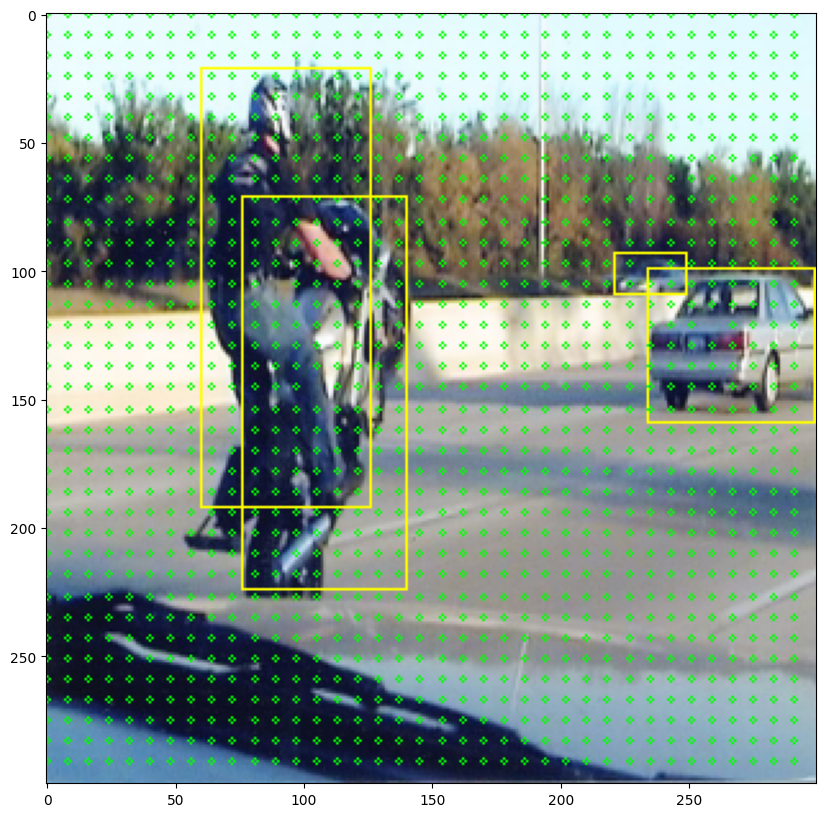

In [21]:
img = img_tensor.numpy() * 255
img = img.astype(np.uint8)
height, width, _ = img.shape

count = 0
for i, box in enumerate(decoded_boxes):
    xmin, ymin, xmax, ymax = box
    umin, vmin = int(xmin * width), int(ymin * height)
    umax, vmax = int(xmax * width), int(ymax * height)
    
    if (xmax - xmin) * (ymax - ymin) == 0:
        cv2.circle(img, (umin, vmin), radius=1, color=(0, 255, 0), thickness=1)
    else:
        cv2.rectangle(img, (umin, vmin), (umax, vmax), color=(255, 255, 0), thickness=1)

    count += 1
    
print(f"visualized {count} boxes")
fig, axs = plt.subplots(1, figsize=(10, 10))
axs.imshow(img)

In [22]:
center_mask, center_cls_heatmap, center_reg_heatmap = encoder.encode(gt_boxes, gt_labels.int())
boxes, scores, labels = encoder.decode(center_cls_heatmap, center_reg_heatmap)

In [25]:
gt_boxes[:5]

tensor([[0.7380, 0.3133, 0.8320, 0.3645],
        [0.7820, 0.3313, 0.9980, 0.5301],
        [0.2560, 0.2380, 0.4700, 0.7470],
        [0.2020, 0.0723, 0.4220, 0.6416]])

In [24]:
boxes[:5]

tensor([[0.2020, 0.0723, 0.4220, 0.6416],
        [0.7380, 0.3133, 0.8320, 0.3645],
        [0.2560, 0.2380, 0.4700, 0.7470],
        [0.7820, 0.3313, 0.9980, 0.5301],
        [0.5676, 0.6486, 0.5676, 0.6486]])

In [27]:
labels[:5]

tensor([15,  7, 14,  7,  0])